In [1]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
from models.unet import *
import torch.optim as optim
from utils.trainer import *
from models.newdif import *
from torch.optim import Adam
from utils.plotters import *
from utils.inference import *
#from models.diffusion import *
from dataset.radardata import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
wandb.init(
    project="New-Radar-diffusion2",
    name="dataset",
    notes="new soft loss",
    config={
        "SNR": [5, 10, 15],
        "CNR": [10, 15, 20],
        "nu": [0.1, 0.5, 1.0],
        "max_lr": 1e-3,
        "beta_end": 0.02,
        "final_lr": 1e-5,
        "num_heads": 8,
        "beta_start": 1e-4,
        "num_layers": 6,
        "batch_size": 16,
        "num_epochs": 400,
        "noise_steps": 2000,
        "num_workers": 4,
        "weight_decay": 1e-4,
        "warmup_steps": 4000,
        "dataset_size": 40000,
        "time_emb_dim": 256,
        "learning_rate": 1e-4,        
        "scheduler_type": "linear",
    },
)
config = wandb.config

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [4]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets, random_n_targets, nu=None, scnr=None, snr=None, cnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.snr_dB = snr
        self.cnr_dB = cnr
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # in dB (only used if snr/cnr are NOT given)

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3       # Range resolution in m
        self.dv = 0.249   # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation (only used if snr/cnr not specified)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        
        # For old scnr logic, we also computed a "normalization" factor
        self.cn_norm = torch.sqrt(
            torch.tensor(
                self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float
            )
        )

    def generate_target_signal(self, ranges, velocities, phases, gains_dB):

        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target
        

        if (self.snr_dB is None) or (self.cnr_dB is None):
            S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
            sig_amp = (10 ** (gains_dB / 20)) * (self.cn_norm / S_norm)
            rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
            return rd_signal
        else:

            rd_signal = rd_signal.sum(dim=0)
            return rd_signal

    def generate_clutter(self, nu):
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)

        p, q = torch.meshgrid(
            torch.arange(self.N, dtype=torch.float),
            torch.arange(self.K, dtype=torch.float),
            indexing='ij'
        )
        M = torch.exp(
            -2 * torch.pi**2 * sigma_f**2 * (p - q)**2
            - 1j * (p - q) * fd * self.T0
        )

        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)  # eigen-decomposition
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z  # shaping the random draws to match M

        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)


        c_r_steer = torch.exp(
            -1j 
            * 2 
            * torch.pi 
            * torch.outer(torch.arange(self.N, dtype=torch.float), self.R)
            * (2 * self.B) / (self.c * self.N)
        )
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):

        W_unscaled = torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C_unscaled = self.generate_clutter(nu)
        

        S_unscaled = torch.zeros(self.N, self.K, dtype=torch.cfloat)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = (
                torch.randint(1, self.n_targets + 1, (1,)).item()
                if self.random_n_targets
                else self.n_targets
            )
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            
            if (self.snr_dB is None) or (self.cnr_dB is None):
                SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
                S_unscaled = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            else:

                S_raw = []
                for i in range(n):
                    s_i = self.generate_target_signal(
                        ranges[i].unsqueeze(-1),
                        velocities[i].unsqueeze(-1),
                        phases[i].unsqueeze(-1),
                        gains_dB=torch.tensor([0.0])  # placeholder
                    )
                    S_raw.append(s_i)
                S_unscaled = sum(S_raw)

            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        if (self.snr_dB is not None) and (self.cnr_dB is not None):
            noise_power  = W_unscaled.abs().pow(2).mean()
            clutter_power= C_unscaled.abs().pow(2).mean() if C_unscaled.numel() > 0 else 0.0
            signal_power = S_unscaled.abs().pow(2).mean() if S_unscaled.numel() > 0 else 0.0

            snr_lin = 10 ** (self.snr_dB / 10)
            cnr_lin = 10 ** (self.cnr_dB / 10)

            alpha_n = torch.sqrt(1.0 / noise_power)
            W = alpha_n * W_unscaled  # final noise
            final_noise_power = W.abs().pow(2).mean()

            if clutter_power > 0:
                alpha_c = torch.sqrt((cnr_lin * final_noise_power) / clutter_power)
                C = alpha_c * C_unscaled
            else:
                C = torch.zeros_like(C_unscaled)

            if signal_power > 0:
                alpha_s = torch.sqrt((snr_lin * final_noise_power) / signal_power)
                S = alpha_s * S_unscaled
            else:
                S = torch.zeros_like(S_unscaled)

        else:
            W = (W_unscaled / torch.sqrt(torch.tensor(self.sigma2)))  # old approach
            C = C_unscaled
            S = S_unscaled

        X = S + C + W
        
        signal_energy  = S.abs().pow(2).sum()
        clutter_energy = C.abs().pow(2).sum()
        noise_energy   = W.abs().pow(2).sum()
        scnr_lin = signal_energy / (clutter_energy + noise_energy + 1e-12)
        scnr_dB  = 10.0 * torch.log10(scnr_lin + 1e-12)

        return S, C, W, X, rd_label, scnr_dB

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = self.gen_frame_and_labels()
        return signal, clutter, gaus_noise, IQ, rd_label, scnr_dB


In [5]:
def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    """
    Generates the range steering matrix R.
    """
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * math.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    """
    Generates the Doppler steering matrix V.
    """
    vel_res = c / (2 * fc * K * T0)
    # Create a symmetric velocity vector
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * math.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map_differentiable(IQ_map):
    """
    Converts a complex IQ (or signal) map to a range–Doppler (RD) map.
    If the input is not already complex, it is cast to torch.complex64.
    Returns the absolute value of the radar return in the RD domain.
    """
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    device = IQ_map.device
    R = generate_range_steering_matrix().to(device)
    V = generate_doppler_steering_matrix().to(device)
    # The steering is applied to convert the input domain to the RD domain.
    RD_map = R.T.conj() @ IQ_map @ V.conj()
    return RD_map

In [6]:
def get_mean_std(radarloader, convert=False):
    IQ_total_sum = 0.0
    IQ_total_sq_sum = 0.0
    IQ_total_samples = 0
    signal_total_sum = 0.0
    signal_total_sq_sum = 0.0
    signal_total_samples = 0
    for signal, _, _, IQ, _, _ in radarloader:
        if convert:
            signal = create_rd_map_differentiable(signal)
            IQ = create_rd_map_differentiable(IQ)
        IQ_total_sum += IQ.real.sum() + IQ.imag.sum() #signal.abs().sum()
        IQ_total_sq_sum += (IQ.real.pow(2).sum() + IQ.imag.pow(2).sum()) #(signal.abs()**2).sum()
        IQ_total_samples += IQ.numel() * 2 # multiply by 2 for real and imaginary 
        signal_total_sum += signal.real.sum() + signal.imag.sum() #signal.abs().sum()
        signal_total_sq_sum += (signal.real.pow(2).sum() + signal.imag.pow(2).sum()) #(signal.abs()**2).sum()
        signal_total_samples += signal.numel() * 2 # multiply by 2 for real and imaginary 
    IQ_mean = IQ_total_sum / IQ_total_samples
    IQ_std = torch.sqrt((IQ_total_sq_sum / IQ_total_samples) - IQ_mean**2)
    signal_mean = signal_total_sum / signal_total_samples
    signal_std = torch.sqrt((signal_total_sq_sum / signal_total_samples) - signal_mean**2)
    return signal_mean, signal_std, IQ_mean, IQ_std

def normalize_and_cache_dataset(dataset, iq_signal_mean, iq_signal_std, iq_IQ_mean, iq_IQ_std, rd_signal_mean, rd_signal_std, rd_IQ_mean, rd_IQ_std):
    signals_norm = []
    rd_signals_norm = []
    IQs_norm = []
    RDs_norm = []
    labels = []
    scnr_dBs = []
    clutter_all = []  
    gauss_all = []   

    for idx in tqdm(range(len(dataset)), desc='Normalizing dataset'):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[idx]
        rd_signal = create_rd_map_differentiable(signal)
        rd_IQ = create_rd_map_differentiable(IQ)
        # Normalize signal
        signal_real_norm = (signal.real - iq_signal_mean) / iq_signal_std
        signal_imag_norm = (signal.imag - iq_signal_mean) / iq_signal_std
        signal_norm = torch.complex(signal_real_norm, signal_imag_norm)
        
        # Normalize IQ
        IQ_real_norm = (IQ.real - iq_IQ_mean) / iq_IQ_std
        IQ_imag_norm = (IQ.imag - iq_IQ_mean) / iq_IQ_std
        IQ_norm = torch.complex(IQ_real_norm, IQ_imag_norm)

        # Normalize rd signal
        rd_signal_real_norm = (rd_signal.real - rd_signal_mean) / rd_signal_std
        rd_signal_imag_norm = (rd_signal.imag - rd_signal_mean) / rd_signal_std
        rd_signal_norm = torch.complex(rd_signal_real_norm, rd_signal_imag_norm)
        
        # Normalize rd IQ
        RD_real_norm = (rd_IQ.real - rd_IQ_mean) / rd_IQ_std
        RD_imag_norm = (rd_IQ.imag - rd_IQ_mean) / rd_IQ_std
        RD_norm = torch.complex(RD_real_norm, RD_imag_norm)

        signals_norm.append(signal_norm)
        IQs_norm.append(IQ_norm)
        rd_signals_norm.append(rd_signal_norm)
        RDs_norm.append(RD_norm)
        labels.append(rd_label)
        scnr_dBs.append(scnr_dB)
        
        # Save clutter and gauss tensors as well
        clutter_all.append(clutter)      # <- added
        gauss_all.append(gaus_noise)     # <- added

    # Stack everything into tensors
    signals_norm = torch.stack(signals_norm)
    IQs_norm = torch.stack(IQs_norm)
    rd_signals_norm = torch.stack(rd_signals_norm)
    RDs_norm = torch.stack(RDs_norm)
    labels = torch.stack(labels)
    scnr_dBs = torch.tensor(scnr_dBs)
    clutter_all = torch.stack(clutter_all)  # <- added
    gauss_all = torch.stack(gauss_all)      # <- added

    # Return cached TensorDataset (now consistent)
    return TensorDataset(signals_norm, rd_signals_norm, IQs_norm, RDs_norm, clutter_all, gauss_all, labels, scnr_dBs)

In [7]:
def prep_dataset(config):
    snr_list = [5]
    cnr_list = [15]
    train_datasets = []
    val_datasets = []
    for snr in snr_list:
        for cnr in cnr_list:
            train_dataset_with_targets = RadarDataset(
                num_samples=config.dataset_size // (len(snr_list) * len(cnr_list)),
                n_targets=8,
                random_n_targets=True,
                snr=snr,
                cnr=cnr
            )
            train_dataset_without_targets = RadarDataset(
                num_samples=config.dataset_size // (10 * len(snr_list) * len(cnr_list)),
                n_targets=0,
                random_n_targets=False,
                snr=snr,
                cnr=cnr
            )
            # Create a dataset for this configuration and add it to the list.
            train_datasets.append(ConcatDataset([train_dataset_with_targets, train_dataset_without_targets]))
            
            val_dataset_with_targets = RadarDataset(
                num_samples=config.dataset_size // (10 * len(snr_list) * len(cnr_list)),
                n_targets=8,
                random_n_targets=True,
                snr=snr,
                cnr=cnr
            )
            val_dataset_without_targets = RadarDataset(
                num_samples=config.dataset_size // (100 * len(snr_list) * len(cnr_list)),
                n_targets=0,
                random_n_targets=False,
                snr=snr,
                cnr=cnr
            )
            val_datasets.append(ConcatDataset([val_dataset_with_targets, val_dataset_without_targets]))
    
    full_train_dataset = ConcatDataset(train_datasets)
    full_val_dataset = ConcatDataset(val_datasets)
    
    train_loader = DataLoader(full_train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(full_val_dataset, batch_size=config.batch_size, shuffle=False)
    
    signal_mean, signal_std, IQ_mean, IQ_std = get_mean_std(train_loader, convert=False)
    rd_signal_mean, rd_signal_std, rd_IQ_mean, rd_IQ_std = get_mean_std(train_loader, convert=True)
    norm_train_dataset = normalize_and_cache_dataset(full_train_dataset, signal_mean, signal_std, IQ_mean, IQ_std,rd_signal_mean, rd_signal_std, rd_IQ_mean, rd_IQ_std)
    norm_val_dataset = normalize_and_cache_dataset(full_val_dataset, signal_mean, signal_std, IQ_mean, IQ_std, rd_signal_mean, rd_signal_std, rd_IQ_mean, rd_IQ_std)
    norm_train_loader = DataLoader(norm_train_dataset, batch_size=config.batch_size, shuffle=True)
    norm_val_loader = DataLoader(norm_val_dataset, batch_size=config.batch_size, shuffle=False)
    
    return norm_train_loader, norm_val_loader, norm_train_dataset, norm_val_dataset

In [8]:
norm_train_loader, norm_val_loader, norm_train_dataset, norm_val_dataset = prep_dataset(config)

Normalizing dataset: 100%|██████████| 4400/4400 [00:08<00:00, 504.91it/s]


In [9]:
torch.save(norm_train_dataset, "norm_train_dataset_1015.pt")
torch.save(norm_val_dataset,   "norm_val_dataset_1015.pt")

Signal shape: torch.Size([64, 64])
RD Signal shape: torch.Size([64, 64])
IQ shape: torch.Size([64, 64])
RD IQ shape: torch.Size([64, 64])
Clutter shape: torch.Size([64, 64])
Gaussian Noise shape: torch.Size([64, 64])
Label shape: torch.Size([64, 64])
SCNR (dB): -10.135210037231445


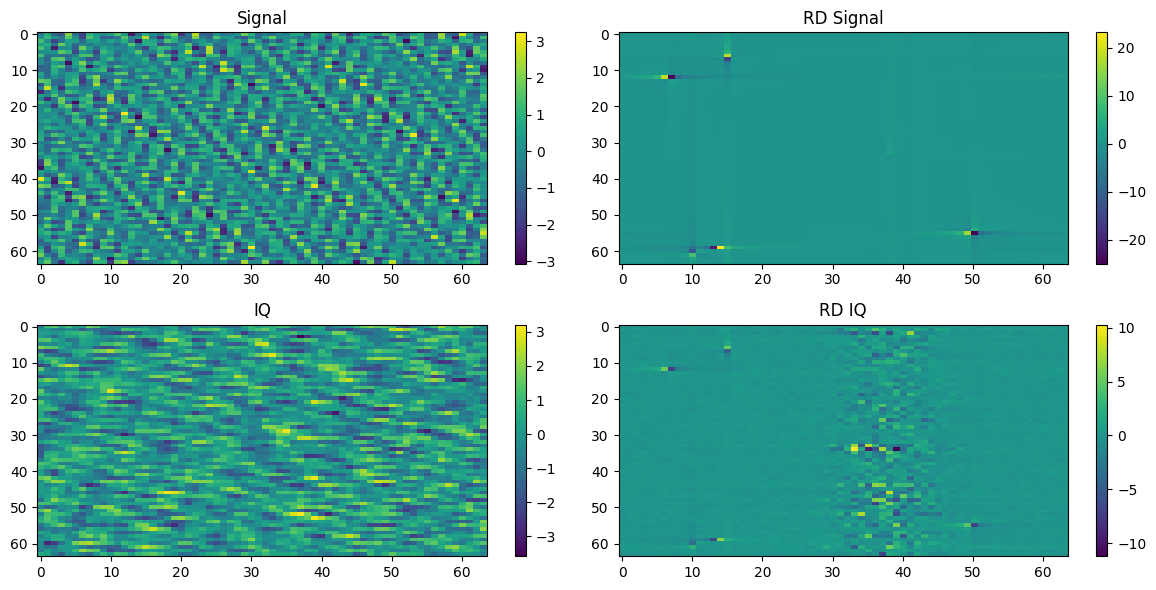

In [16]:
# explore the dataset
for i in range(1):
    signal, rd_signal, IQ, rd_IQ, clutter, gaus_noise, label, scnr_dB = norm_train_dataset[i]
    print(f"Signal shape: {signal.shape}")
    print(f"RD Signal shape: {rd_signal.shape}")
    print(f"IQ shape: {IQ.shape}")
    print(f"RD IQ shape: {rd_IQ.shape}")
    print(f"Clutter shape: {clutter.shape}")
    print(f"Gaussian Noise shape: {gaus_noise.shape}")
    print(f"Label shape: {label.shape}")
    print(f"SCNR (dB): {scnr_dB.item()}")
# Plotting the first sample
signal, rd_signal, IQ, rd_IQ, clutter, gaus_noise, label, scnr_dB = norm_train_dataset[1]
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title("Signal")
plt.imshow(signal.real.cpu().numpy(), aspect='auto')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title("RD Signal")
plt.imshow(rd_signal.real.cpu().numpy(), aspect='auto')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.title("IQ")
plt.imshow(IQ.real.cpu().numpy(), aspect='auto')
plt.colorbar()
plt.subplot(2, 2, 4)
plt.title("RD IQ")
plt.imshow(rd_IQ.real.cpu().numpy(), aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.show()

